In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.cosmology
import scipy.stats
import time
from useful_funcs import PAUSflux_to_ABmag
import h5py
import matplotlib.colors
import os
from SAVEFIG import main as custom_SAVEFIG

latex_textwidth = 455.24#pt

def fixed_aspect_ratio(ratio):
    '''
    Set a fixed aspect ratio on matplotlib plots 
    regardless of axis units
    '''
    xvals,yvals = plt.gca().axes.get_xlim(),plt.gca().axes.get_ylim()

    xrange = xvals[1]-xvals[0]
    yrange = yvals[1]-yvals[0]
    plt.gca().set_aspect(ratio*(xrange/yrange), adjustable='box')

#matplotlib.rcParams['agg.path.chunksize'] = 10000

In [2]:
from astropy.cosmology import Planck15 as cosmo

cosmo = cosmo.clone(name='Planck15 H0 = 100', H0=100) #setting H0 = 100 km/s/MPc, h = 1


In [3]:
data = pd.read_pickle("../../Data/Object_zs_zp_181203_130401.pkl.gz")


lcCoreFilename = "Gonzalez13.PAU.MillGas.field1.core.0.hdf5"
lcPhotomFilename = "Gonzalez13.PAU.MillGas.field1.photometry.0.hdf5"

if os.environ['NAME'] == 'DESKTOP-RB5C8OC': 
    file_path = '/mnt/e/L4ProjectLocal/LightConeData/'
elif os.environ['NAME'] == 'LaNaranjaDos':
    file_path = '/mnt/c/Users/Andrew/L4ProjectLocal/Light Cone Data/'
else: raise Exception('Device not configured for hdf5 data load')

LC_DATA_CORE = h5py.File(file_path+lcCoreFilename, "r")
LC_DATA_PHOTOM = h5py.File(file_path+lcPhotomFilename, "r")

Save figure? (y/n)


/home/andrew/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:2551: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/home/andrew/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:4197: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/home/andrew/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:838: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()


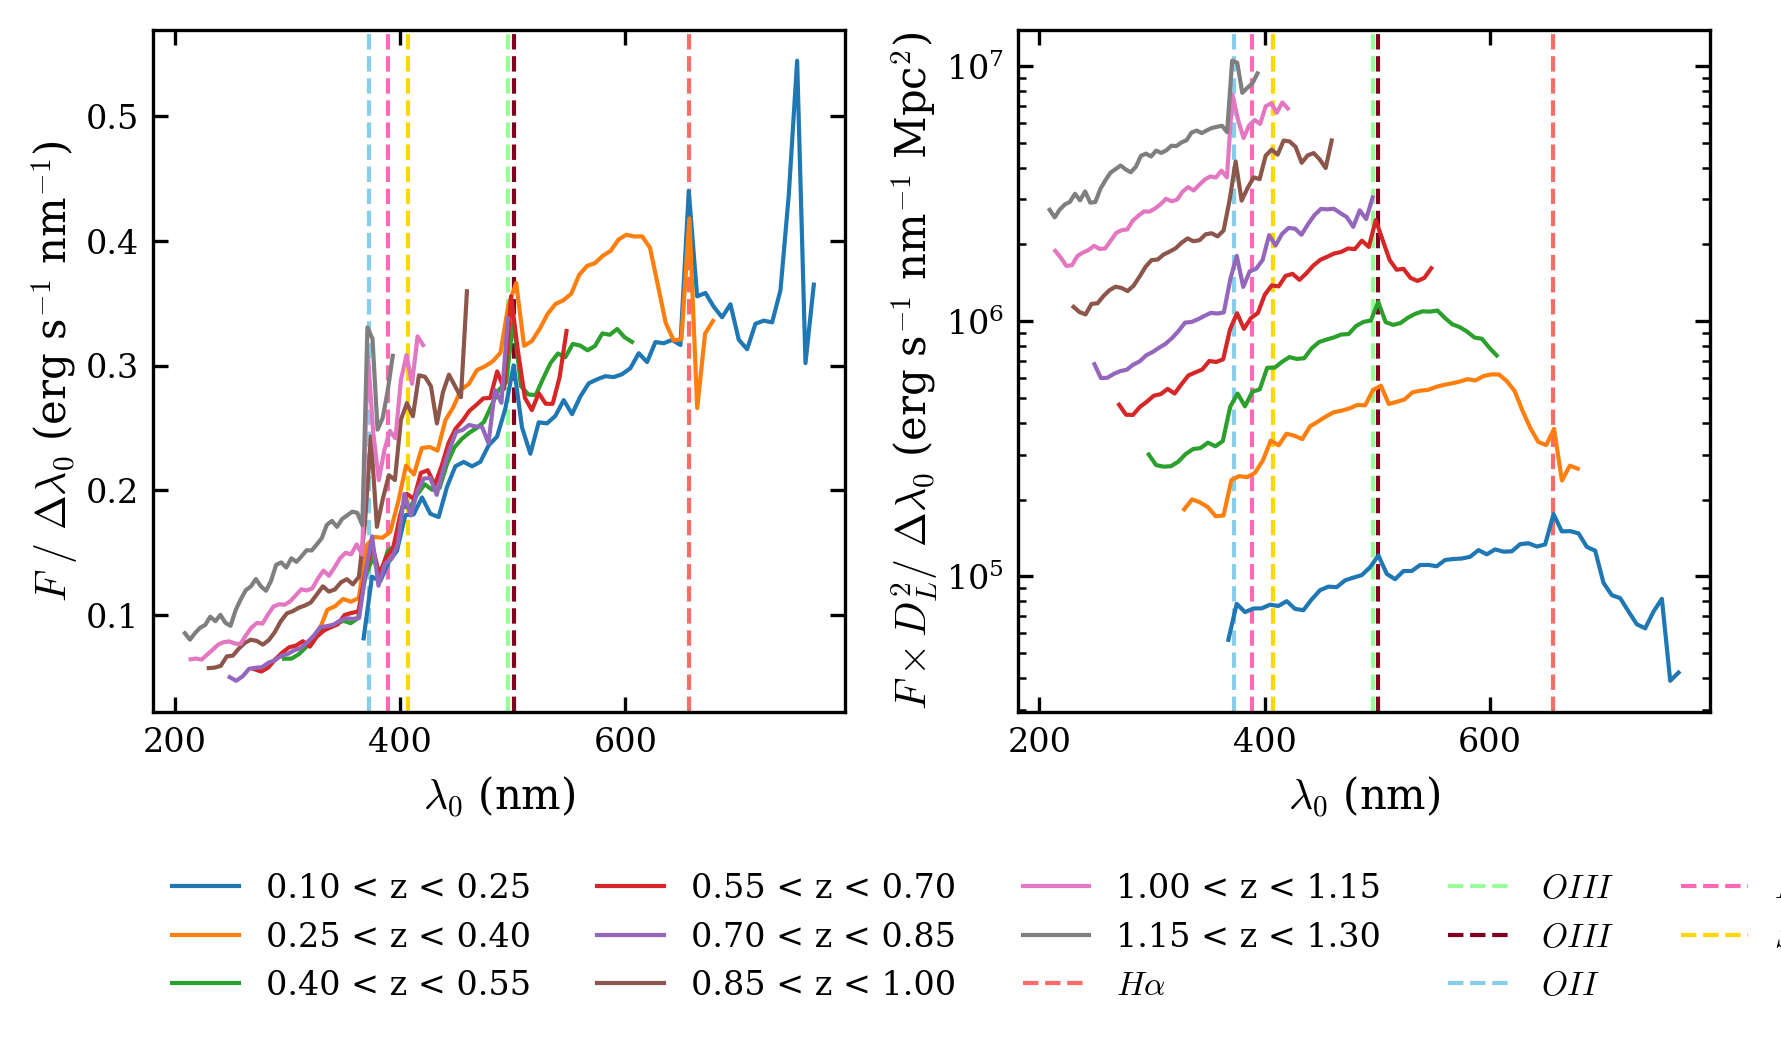

In [4]:
mask = data['conf'].astype('str').str.match('^[34]\.[0-9]$') | data['conf'].astype('str').str.match('^[29]\.5$') 
data_sample = data.loc[(data['n_bands']>=30)]# & mask & (data['zspec']!=0)]

lum_dists_1d = cosmo.luminosity_distance(data_sample['zb']).value
luminosity_distances = np.repeat(lum_dists_1d[:,None],40,axis=1)
z_photos = data_sample['zb']




################################# PLOT 1 #################################



# bins = [[0.1,0.27],[0.2,0.38],[0.3,0.5],[0.4,0.61],[0.5,0.72],[0.6,0.84],[0.7,0.96],[0.8,1.07],[0.9,1.19],[1,1.3],[1.1,1.42]]
bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]]) 

factor = 1/8.5 * latex_textwidth/72

fig = plt.figure(figsize=(7.5*factor*1.2,8.5*factor*0.62),dpi=300)
ax1 = plt.subplot(121)

band_obsframe = data_sample.loc[:,'band0':'band39'].values/(data_sample['zb'].values[:,None]+1)


increments = np.linspace(90,150,len(bins))

all_means = []
bandwidtharray = np.linspace(7.4,4.5,len(bins))


for ind,z_bin in enumerate(bins):
#     band_bins,step = np.linspace(200,860,increments[ind],retstep=True)
#     print("wl bin step = {:3.2f}".format(step))

    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1])
    lamb_sample = band_obsframe[truth_table].flatten()
    flux_sample = data_sample.loc[truth_table,'band0_flux':'band39_flux'].values.flatten()
    z_samp = np.repeat(z_photos[truth_table],40)
#     print(z_samp)
#     print(z_samp.size,flux_sample.size,z_photos.size)
    lum_dist_sample = luminosity_distances[truth_table].flatten()
    
    band_width = bandwidtharray[ind]
#     print(lamb_sample.min(),lamb_sample.max())
    band_bins = np.arange(np.nanmin(lamb_sample),np.nanmax(lamb_sample)+band_width,band_width)
    
#     flux_sample = 10**((26-flux_sample)/2.5) #<---- AB mag to flux conversion
    
    N_objects = band_obsframe[truth_table].shape[0]
    
    digitized = np.digitize(lamb_sample,band_bins)
    #Pre- broken
#     binned_means = [np.nanmedian(flux_sample[digitized == i]) for i in range(1,len(band_bins))]
#     all_means.append(binned_means/(band_bins[1:]+band_bins[:-1])*2) #flux(in AB mags)/band wl
#     plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means)/(band_bins[1:]+band_bins[:-1])*2,\
#              label="{:.02f} < z < {:.02f}, N = {}".format(z_bin[0],z_bin[1],N_objects)) #flux(in AB mags)/500 band wl


    binned_means = [np.nanmedian(flux_sample[digitized == i]/130*(1+z_samp[digitized == i])) for i in range(1,len(band_bins))]
    all_means.append(binned_means) #flux(in AB mags)/band wl
    plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means),\
             zorder=10) #flux(in AB mags)/500 band wl
    

                                 
        

# print(np.array(all_means))
# plt.plot((band_bins[1:]+band_bins[:-1])/2,np.nanmedian(np.array(all_means),axis=0),'k-',linewidth=3,label="Median SED")

emis_lines = [[656.28,r'$H\alpha$'],[496,r'$OIII$'],[500.8,r'$OIII$'],[372.8,r"$OII$"],[388.9,r'$HeI$'],[407.2,r'$SII$']]
colours = ['#ff6b6b','#98ff98','#800020','skyblue','hotpink','gold','black','white']
for i,line in enumerate(emis_lines):
#     random_ints = np.random.randint(256,size=3)
# color = #{}{}{}'.format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2))
    plt.axvline(line[0],color=colours[i],linestyle='--',zorder=1)

plt.xlabel(r'$\lambda_0$ (nm)')
plt.ylabel(r'$F\ /\ \Delta\lambda_0$ (erg s$^{-1}$ nm$^{-1}$)')
# plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1),ncol=2,frameon=False)
# fixed_aspect_ratio(1)
# custom_SAVEFIG(filetag='SED_LD')

# plt.yscale('log')
# plt.ylim([0,2.5e6])
#plt.xlim([200,680])
# plt.show()



################################# PLOT 2 #################################
ax2 = plt.subplot(122)

bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]]) 

# bins = [[0.7,0.75],[0.75,0.8],[0.8,0.85]]
max_factor = 7.25
# factor = 1/max_factor*latex_textwidth/72
# fig = plt.figure(figsize=(7.5*factor,max_factor*factor),dpi=300)

band_obsframe = data_sample.loc[:,'band0':'band39'].values/(data_sample['zb'].values[:,None]+1)
# print(band_obsframe.min(),band_obsframe.max())

increments = np.linspace(90,150,len(bins))

# print(band_obsframe,band_bins)
all_means = []
# print(data.loc[(data['imag']==0)|(data['rmag']==0)|(data['odds']<0)]['flux'])
# band_bins = np.arange(200,860,band_bin_incs[ind])

for ind,z_bin in enumerate(bins):
#     band_bins,step = np.linspace(200,860,increments[ind],retstep=True)
#     print("wl bin step = {:3.2f}".format(step))
#     print(band_bins)
    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1])
    lamb_sample = band_obsframe[truth_table].flatten()
    flux_sample = data_sample.loc[truth_table,'band0_flux':'band39_flux'].values.flatten()
    lum_dist_sample = luminosity_distances[truth_table].flatten()
    z_samp = np.repeat(z_photos[truth_table],40)
    band_width = bandwidtharray[ind]
#     print(lamb_sample.min(),lamb_sample.max())
    band_bins = np.arange(np.nanmin(lamb_sample),np.nanmax(lamb_sample)+band_width,band_width)
#     print(lamb_sample.shape,flux_sample.shape,lum_dist_sample.shape)
    
#     flux_sample = 10**((26-flux_sample)/2.5) #<---- AB mag to flux conversion
    
    N_objects = band_obsframe[truth_table].shape[0]
    
    digitized = np.digitize(lamb_sample,band_bins)
# Pre-changed
#     binned_means = [np.nanmedian(flux_sample[digitized == i] * lum_dist_sample[digitized == i]**2) for i in range(1,len(band_bins))]
#     all_means.append(binned_means/(band_bins[1:]+band_bins[:-1])*2) #flux(in AB mags)/band wl
# #     print (binned_means)
    
#     plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means)/(band_bins[1:]+band_bins[:-1])*2,\
#              label="{:.02f} < z < {:.02f}, N = {}".format(z_bin[0],z_bin[1],N_objects)) #flux(in AB mags)/500 band wl
    
    
    binned_means = [np.nanmedian(flux_sample[digitized == i]/130*(1+z_samp[digitized == i])*lum_dist_sample[digitized == i]**2) for i in range(1,len(band_bins))]
    all_means.append(binned_means) #flux(in AB mags)/band wl
    plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means),\
             label="{:.02f} < z < {:.02f}".format(z_bin[0],z_bin[1]),zorder=10) #flux(in AB mags)/500 band wl

# print(np.array(all_means))
# plt.plot((band_bins[1:]+band_bins[:-1])/2,np.nanmedian(np.array(all_means),axis=0),'k-',linewidth=3,label="Median SED")

emis_lines = [[656.28,r'$H\alpha$'],[496,r'$OIII$'],[500.8,r'$OIII$'],[372.8,r"$OII$"],[388.9,r'$HeI$'],[407.2,r'$SII$']]

for i,line in enumerate(emis_lines):
#     random_ints = np.random.randint(256,size=3)
# color = #{}{}{}'.format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2))
    plt.axvline(line[0],label=line[1],color=colours[i],linestyle='--',zorder=1)

plt.xlabel(r'$\lambda_0$ (nm)')
plt.ylabel(r'$F \times D_L^2 /\ \Delta\lambda_{0}$ (erg s$^{-1}$ nm$^{-1}$ Mpc$^2$)')
fig.legend(loc=10, bbox_to_anchor=(0.5,0.1), ncol=5,frameon=False,fontsize=8)

# ax1.tick_params(labelbottom=False)

plt.yscale('log')
# plt.ylim([0,2.5e6])
#plt.xlim([200,680])
fixed_aspect_ratio(1)

fig.subplots_adjust(wspace=0.25)
fig.subplots_adjust(bottom=0.3)
ax1.yaxis.labelpad, ax2.yaxis.labelpad = 1,1


custom_SAVEFIG(filetag='SED_LD')
plt.show()



/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  del sys.path[0]


Save figure? (y/n)


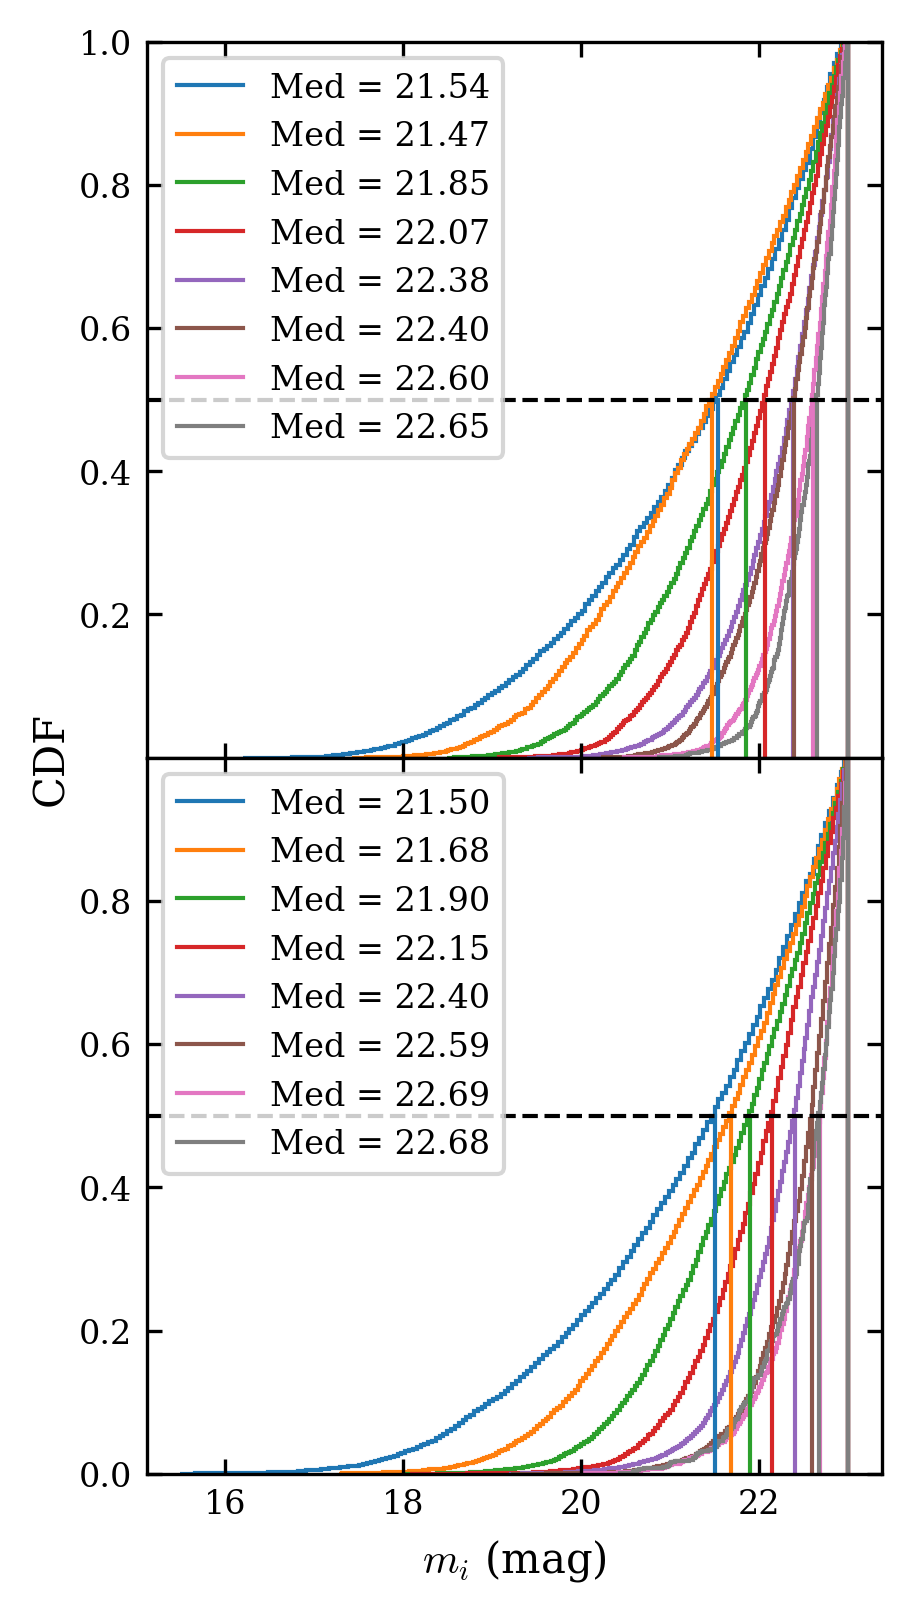

In [5]:
factor = latex_textwidth/72*0.5
fig = plt.figure(figsize=(1*factor,2*factor),dpi=300)
ax1 = plt.subplot(211)
bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]])

increments = np.linspace(90,150,len(bins))
for ind,z_bin in enumerate(bins):
    band_bins,step = np.linspace(200,860,increments[ind],retstep=True)
#     print("wl bin step = {:3.2f}".format(step))

    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1]) & (data_sample['imag']!=0)
    
#     lamb_sample = band_obsframe[truth_table].flatten()
    
    iband_mags = data_sample.loc[truth_table,'i_auto']
    N_objects = iband_mags.size
    median = np.median(iband_mags)
#     digitized = np.digitize(lamb_sample,band_bins)
#     binned_means = [np.nanmedian(iband_mags[digitized == i]) for i in range(1,len(band_bins))]
    hist = plt.hist(iband_mags,175,histtype='step',density=True,cumulative=True)#,label='{:.02f} < z < {:.02f}, N = {}'.format(z_bin[0],z_bin[1],N_objects))
#     plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
#                 label='{:.02f} < z < {:.02f}, Med = {:4.2f}'.format(z_bin[0],z_bin[1],median))
    plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
                label='Med = {:4.2f}'.format(median))

plt.axhline(0.5,color='black',linewidth=1,linestyle='--')
# plt.xlabel('$i$ band apparent magnitude (mag)')
# plt.ylabel('Cumulative Normalised distribution (CDF)')
plt.ylim((0,1))
plt.legend(fontsize=8)
# custom_SAVEFIG('PAUS_CDF')
# plt.show()
# locs, labels = plt.xticks()
plt.yticks(plt.yticks()[0][1:])
    
ax2 = plt.subplot(212,sharex=ax1)

imags = np.array(LC_DATA_CORE['Data/appMio_tot_ext'])
zs = np.array(LC_DATA_CORE['Data/z_obs'])
LC_ras = np.array(LC_DATA_CORE['Data/ra'])
LC_decs = np.array(LC_DATA_CORE['Data/dec'])

mask = (imags<23) & (LC_ras < np.median(LC_ras)+1) & (LC_ras > np.median(LC_ras)-1) & (LC_decs < np.median(LC_decs)+0.5) & (LC_decs > np.median(LC_decs)-0.5)

zs = zs[mask]
imags = imags[mask]

# print(zs.min(),zs.max())

# plt.figure(figsize=(1*factor,1*factor),dpi=300)

bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]])

for ind,z_bin in enumerate(bins):
    
    truth_table = (zs >= z_bin[0]) & (zs <= z_bin[1]) 
    
    iband_mags = imags[truth_table]
    N_objects = iband_mags.size
    median = np.median(iband_mags)

    hist = plt.hist(iband_mags,175,histtype='step',density=True,cumulative=True)#,label='{:.02f} < z < {:.02f}, N = {}'.format(z_bin[0],z_bin[1],N_objects))
#     plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
#                 label='{:.02f} < z < {:.02f}, Med = {:4.2f}'.format(z_bin[0],z_bin[1],median))
    plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
                label='Med = {:4.2f}'.format(median))

plt.axhline(0.5,color='black',linewidth=1,linestyle='--')
plt.xlabel('$i_{AB}$ (mag)')
# plt.ylabel('Cumulative Normalised distribution (CDF)')
plt.ylim((0,1))
plt.legend(loc='upper left',fontsize=8)

# custom_SAVEFIG('MOCK_SUBSECTION_CDF')
fig.subplots_adjust(hspace=0)
plt.text(-0.13,0,'CDF',horizontalalignment='center',\
          verticalalignment='center', transform=ax1.transAxes,rotation='vertical',fontsize=10)

plt.yticks(plt.yticks()[0][:-1])



custom_SAVEFIG('CDF_COMBINED_PAUS_MOCK')


plt.show()

In [6]:
imags = np.array(LC_DATA_PHOTOM['Data/appOio_tot_ext'])
ra = np.array(LC_DATA_CORE['Data/ra'])
dec = np.array(LC_DATA_CORE['Data/dec'])
zs = np.array(LC_DATA_CORE['Data/z_cos'])

In [7]:

bins = []
bin_range = [0.1,1.3]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]])
# print(bins)

ra_bins = np.arange(129,142,2)
dec_bins = np.arange(-2,4,1)

zbin_medians = []

for ra_idx in range(ra_bins.size-1):
    for dec_idx in range(dec_bins.size-1):
        
        temp_list = []
        for z_idx,z_bin in enumerate(bins):
            
            truth_table = (zs >= z_bin[0]) & (zs <= z_bin[1]) & (ra >= ra_bins[ra_idx]) & (ra <= ra_bins[ra_idx+1])\
            & (dec >= dec_bins[dec_idx]) & (ra <= ra_bins[dec_idx+1])
#             print(truth_table.sum())
            temp_list.append(np.median(imags[truth_table]))
        
        zbin_medians.append(temp_list)
        
        
meds = np.array(zbin_medians)
# print(meds)

/home/andrew/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/andrew/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Save figure? (y/n)


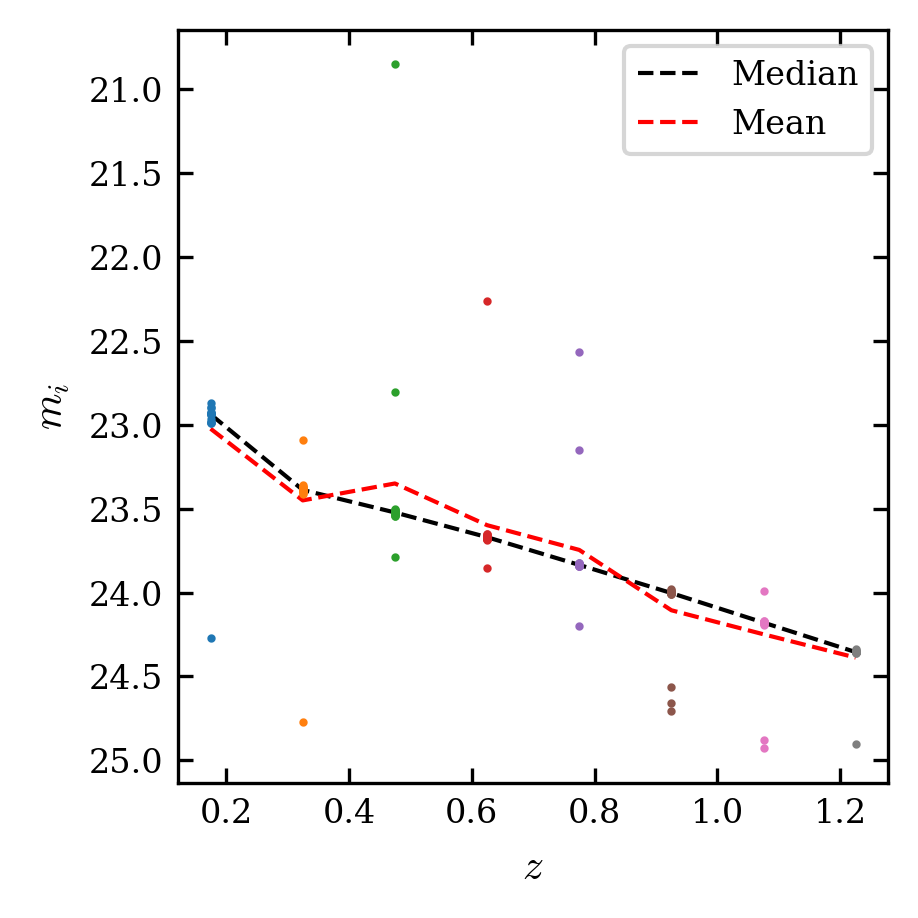

In [8]:
factor = latex_textwidth/72*0.5

plt.figure(figsize=(factor,factor),dpi=300)
z_bin_centres = (temp_bins[:-1]+temp_bins[1:])/2

for i in range(meds.shape[1]):
    z_bin = bins[i]
    plt.scatter([z_bin_centres[i] for j in range(meds.shape[0])],meds[:,i],s=1,zorder=5)
    
# print(meds)
median_ = np.nanmedian(meds,axis=0)
mean_ = np.nanmean(meds,axis=0)

# lbs = scipy.stats.binned_statistic(z_bin_centres,z_bin_centres,lb68,temp_bins)[0]
# ubs = scipy.stats.binned_statistic(z_bin_centres,z_bin_centres,ub68,temp_bins)[0]

plt.plot(z_bin_centres,median_,'k--',label='Median',zorder=1)
plt.plot(z_bin_centres,mean_,'r--',label='Mean',zorder=2)



# print(z_bin_centres,median_)

plt.gca().invert_yaxis()

plt.xlabel('$z$')
plt.ylabel('$m_i$')
plt.legend(loc='upper right')
plt.tight_layout()
custom_SAVEFIG('MEDIAN_iband_redshift')

plt.show()



In [9]:
def ub68(x):
    return np.percentile(x,50+34.1)

def lb68(x):
    return np.percentile(x,50-34.1)

/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this

Save figure? (y/n)


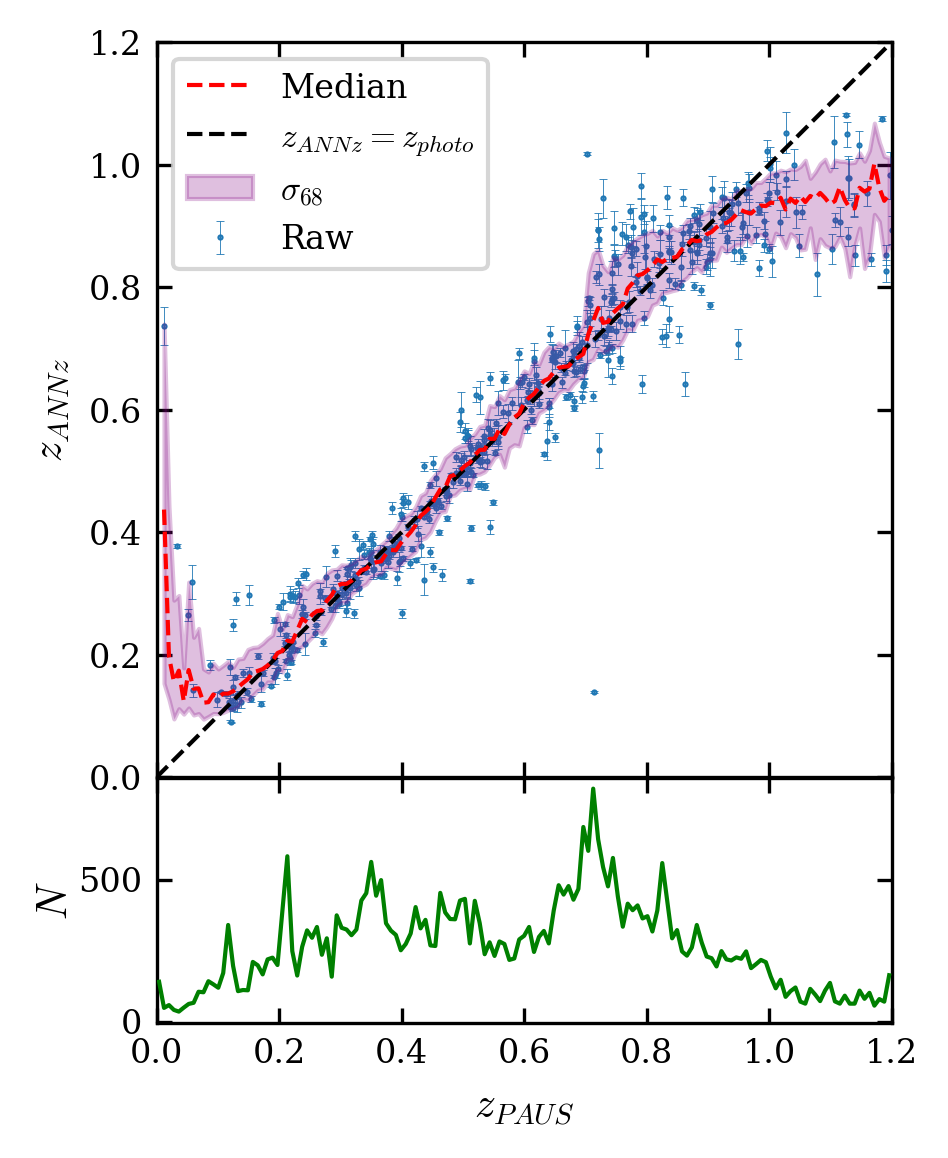

In [10]:
ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced2/regres/eval_nFile0/ANNZ_randomReg_0000.csv',header=0)
# ML_DATA
# print(ML_DATA.shape)
N_points = 500
indices = np.random.choice(ML_DATA.shape[0],N_points,replace=False)

min_bin, max_bin, N_bin = 0,1.2,150
bins = np.linspace(min_bin, max_bin, N_bin)
meds,edge,counts = scipy.stats.binned_statistic(ML_DATA['F:Z'],ML_DATA['F:ANNZ_best'],'median',bins=bins)
lbs = scipy.stats.binned_statistic(ML_DATA['F:Z'],ML_DATA['F:ANNZ_best'],lb68,bins)[0]
ubs = scipy.stats.binned_statistic(ML_DATA['F:Z'],ML_DATA['F:ANNZ_best'],ub68,bins)[0]


factor = latex_textwidth/72*0.5
# fig = plt.figure(figsize=(factor*1.2,factor),dpi=300)
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3, 1]},figsize=(1*factor,1.37*factor),dpi=300,sharex=True)

ax1.errorbar(ML_DATA.loc[indices,'F:Z'],ML_DATA.loc[indices,'F:ANNZ_best'],yerr=ML_DATA.loc[indices,'F:ANNZ_best_err']\
             ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw'.format(N_points),zorder=1)
ax1.plot((bins[:-1]+bins[1:])/2,meds,'r--',label='Median',zorder=5,linewidth=1)
ax1.plot([0,1.2],[0,1.2],'k--',label=r'$z_{ANNz}=z_{photo}$',zorder=4,linewidth=1)
ax1.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
ax2.set_xlabel(r'$z_{PAUS}$')
ax1.set_ylabel(r'$z_{ANNz}$')
ax1.legend(fontsize=8)
ax1.set_xlim(0,1.2)
ax1.set_ylim(0,1.2)
ax1.set_aspect('equal')

# ax2 = plt.subplot(212)
unique, counted = np.unique(counts, return_counts=True)
# print(unique,'\n',counted)
# ax2.plot((bins[:-1]+bins[1:])/2,counted/(max_bin-min_bin)*N_bin,'g-',zorder=5,linewidth=1)
# ax2.set_ylabel('$n$') #object density
ax2.plot((bins[:-1]+bins[1:])/2,counted,'g-',zorder=5,linewidth=1)
ax2.set_ylabel('$N$')
ax2.yaxis.labelpad=0.5


fig.subplots_adjust(hspace=0)
custom_SAVEFIG('ML')

plt.show()

In [11]:
# ML_DATA

Save figure? (y/n)


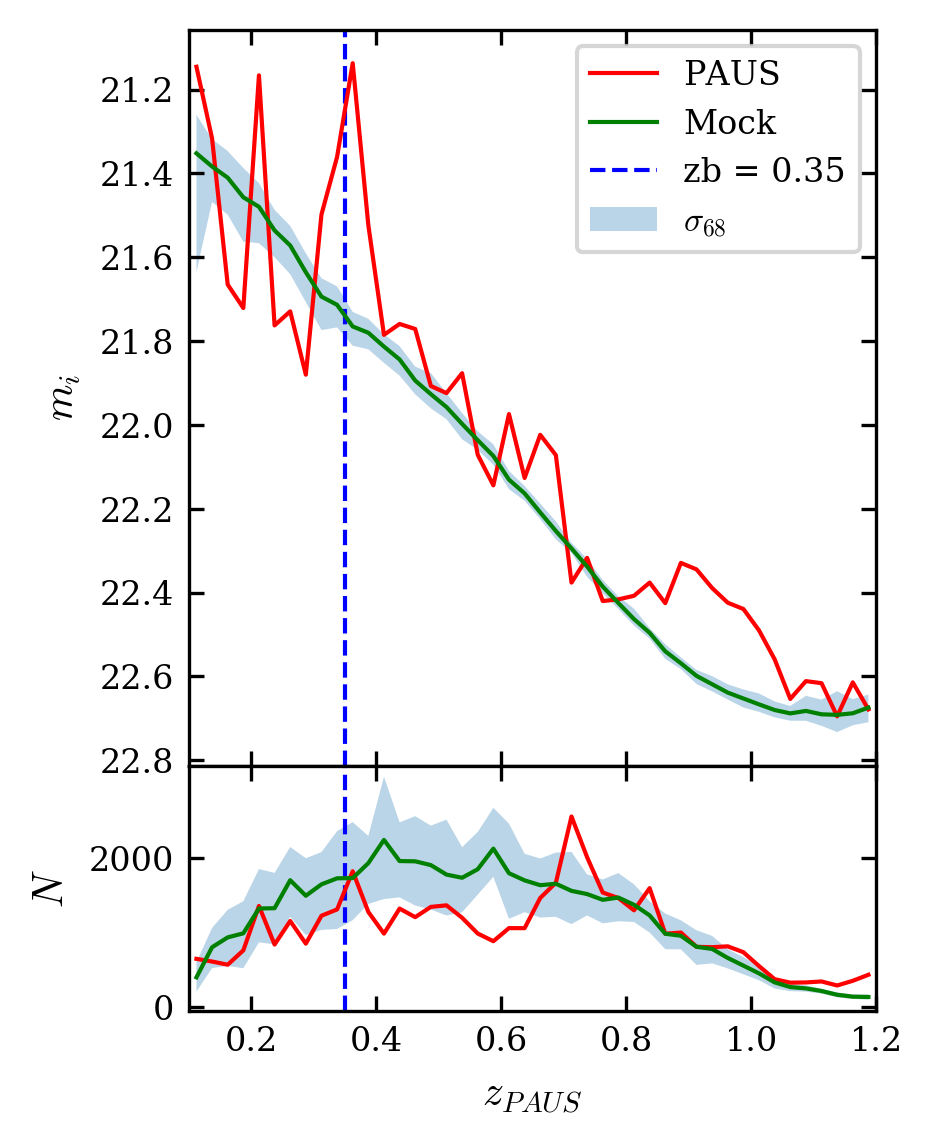

In [12]:
factor = latex_textwidth/72*0.5
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3, 1]},figsize=(1*factor,1.37*factor),dpi=300,sharex=True)


# ax = plt.subplot(331+i)
bins = []
bin_range = [0.1,1.2]
#     print(bin_range)

bin_increment = 0.025
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]])

LC_zs = np.array(LC_DATA_CORE['Data/z_cos'])
LC_imags = np.array(LC_DATA_PHOTOM['Data/appOio_tot_ext'])
LC_ras = np.array(LC_DATA_CORE['Data/ra'])
LC_decs = np.array(LC_DATA_CORE['Data/dec'])

#CUT
mag_cut = 23
mask = LC_imags < mag_cut
# LC_zs, LC_imags = LC_zs[mask], LC_imags[mask]
    

RA_incs = range(129,142,2)
DEC_incs = range(-2,4,1)
RA_list, DEC_list = [], []

for i in range(len(RA_incs)-1):
    RA_list.append([RA_incs[i],RA_incs[i+1]])

for i in range(len(DEC_incs)-1):
    DEC_list.append([DEC_incs[i],DEC_incs[i+1]])

median_imags_PA,bins,dig_P = scipy.stats.binned_statistic(data_sample['zb'],data_sample['i_auto'],'median',temp_bins)
unique, counts_P = np.unique(dig_P,return_counts=True)

median_imags_LC,bins, dig_L = scipy.stats.binned_statistic(LC_zs[mask],LC_imags[mask],'median',temp_bins)



mid_zbins = (temp_bins[1:]+temp_bins[:-1])/2
median_imag_LC_segments = []
counts_segs = []

for ra_bin in RA_list:
#     print(ra_bin)
    for dec_bin in DEC_list:
#         print(dec_bin)
        mask = (LC_ras > ra_bin[0]) & (LC_ras < ra_bin[1]) & (LC_decs > dec_bin[0]) & (LC_decs < dec_bin[1]) & (LC_imags < mag_cut) & (LC_zs <= 1.2)
        zs_temp, imags_temp = LC_zs[mask], LC_imags[mask]
#         print(mask.sum())
        medians, bins, digs =  scipy.stats.binned_statistic(zs_temp,imags_temp,'median',temp_bins)
        
        median_imag_LC_segments.append(medians)
        unique, counts = np.unique(digs,return_counts=True)
#         print(bins.size,unique.size)
        counts_segs.append(counts)
        
#         print(median_imag_LC_segment)
#         plt.plot(mid_zbins,median_imag_LC_segment,'--')

# np.savetxt('test1.txt',digs)
# np.savetxt('test4.txt',zs_temp)
# np.savetxt('test2.txt',bins)
# np.savetxt('test3.txt',dig_P)

counts_segs_ = counts_segs[0]
counts_segs_ = np.concatenate((counts_segs_[None,:],counts_segs[1][None,:]),axis=0)

for i in range(len(counts_segs)-2):
    counts_segs_ = np.concatenate((counts_segs_,counts_segs[i+2][None,:]),axis=0)
# print(counts_segs_.shape)


median_imag_LC_segments = np.array(median_imag_LC_segments)
lb68_ = np.percentile(median_imag_LC_segments,50-34.1,axis=0)
ub68_ = np.percentile(median_imag_LC_segments,50+34.1,axis=0)

lb_counts = np.percentile(counts_segs_[:,1:],50-34.1,axis=0)
ub_counts = np.percentile(counts_segs_[:,1:],50+34.1,axis=0)

# for i in range(median_imag_LC_segments.shape[0]):
#     ax1.plot(mid_zbins,median_imag_LC_segments[i])

ax1.plot(mid_zbins,median_imags_PA,'r-',label='PAUS')
ax1.plot(mid_zbins,median_imags_LC,color='green',label='Mock')
ax1.fill_between(mid_zbins,lb68_,ub68_,alpha=0.3,label=r'$\sigma_{68}$')
# ax1.legend()
ax2.set_xlabel('$z_{PAUS}$')
ax1.set_xlim([0.1,1.2])
ax1.set_ylabel('$m_i$')
ax2.plot(mid_zbins,counts_P[1:],'r-',label='PAUS')
ax2.plot(mid_zbins,counts_segs_[:,1:].mean(axis=0),'g-',label='Mean across Mock segments')
ax2.fill_between(mid_zbins,lb_counts,ub_counts,alpha=0.3,zorder=1,label='$\omega_{68}$')
# ax2.legend(fontsize=8)
ax2.set_ylabel('$N$')

redshiftdip = 0.35
ax1.axvline(redshiftdip,linestyle='--',color='blue',zorder=1,label='zb = {}'.format(redshiftdip))
ax2.axvline(redshiftdip,linestyle='--',color='blue',zorder=1)
ax1.invert_yaxis()

ax1.legend(fontsize=8)
# print(counts_segs_[:,1:].mean(axis=0),'\n',counts_P[1:])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(left=0.175)
custom_SAVEFIG('MEDIAN_i_BAND')
plt.show()


Save figure? (y/n)


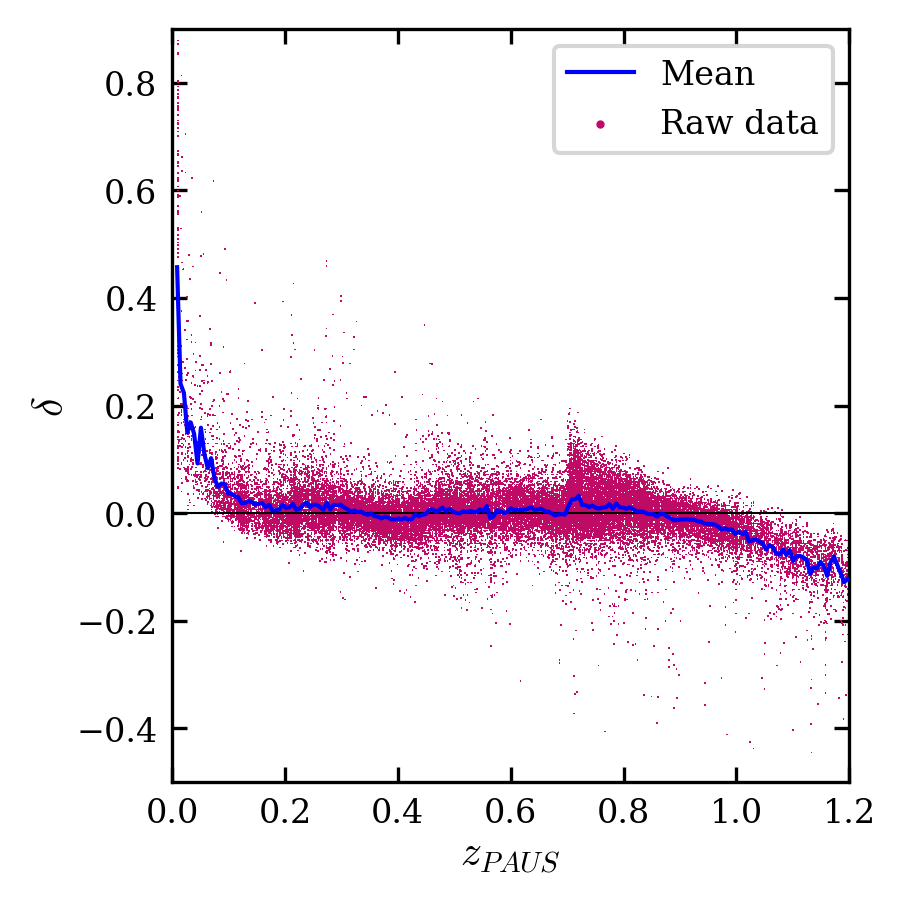

In [13]:
z_annz = ML_DATA['F:ANNZ_best']
z_paus = ML_DATA['F:Z']

r1, g1, b1 = 255, 235, 247
r1, g1, b1 = r1/255, g1/255, b1/255

cdict1 = {'red':   ((0.0, r1, r1),
                   (1.0, 0.75, 0.75)),

         'green': ((0.0, g1, g1),
                   (1.0, 0.04, 0.04)),

         'blue':  ((0.0, b1, b1),
                   (1.0, 0.4, 0.4)),
          
         'alpha': ((0.0, 0.0, 0.0),
                   (1e-20, 1.0, 1.0),
                    (1.0, 1.0, 1.0))
        }

clear_purple = matplotlib.colors.LinearSegmentedColormap('ClearPurple', cdict1)
plt.register_cmap(cmap=clear_purple)

error = z_annz - z_paus
normed_error = error / (1+z_paus)

N_points = 1e4
# print(ML_DATA.shape,N_points)

bins = np.linspace(0,1.2,200)
mean,edge,counts = scipy.stats.binned_statistic(ML_DATA['F:Z'],normed_error,'mean',bins=bins)

indices = np.random.choice(ML_DATA.shape[0],int(N_points),replace=False)

factor = latex_textwidth/72*0.5
plt.figure(figsize=(factor,factor),dpi=300)
# plt.scatter(z_paus.loc[indices],normed_error.loc[indices],s=0.1)
pixs = 1000
bounds = [0,0.9,1e6]
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# hist = plt.hist2d(z_paus.loc[:],normed_error.loc[:],[pixs,pixs],cmap='ClearPurple',zorder=2)

hist = plt.hist2d(z_paus.loc[:],normed_error.loc[:],[pixs,pixs],norm=norm,cmap='ClearPurple',zorder=2)
# norm=matplotlib.colors.LogNorm()
plt.plot((bins[1:]+bins[:-1])/2,mean,'b-',zorder=10,label='Mean')
plt.axhline(linewidth=0.5,zorder=3,color='black')
plt.ylabel('$\delta$')
plt.xlabel('$z_{PAUS}$')

plt.scatter([-1],[-1],s=1,color='#c10968',label='Raw data')
plt.xlim(0,1.2)
plt.ylim(-0.5,0.9)

# plt.colorbar(hist[3])
plt.legend()
plt.tight_layout()
plt.gca().xaxis.labelpad = 1
plt.gca().yaxis.labelpad = 1
custom_SAVEFIG('ML_ERROR')
plt.show()

In [14]:
outliers_idx = abs(normed_error) > 0.15
out_perc = outliers_idx.sum()/outliers_idx.size *100

print("\
Mean normed error                             = {:1.2e} \n\
st. dev of normed error                       = {:.3f}\n\
Percentage of 'catastrophic' outliers         = {:.3f}%\n\
half width of 68th percentile of normed error = {:.3f}"\
.format(normed_error.mean(),np.std(normed_error),out_perc,(ub68(normed_error)-lb68(normed_error))/2))

Mean normed error                             = 1.87e-03 
st. dev of normed error                       = 0.057
Percentage of 'catastrophic' outliers         = 1.756%
half width of 68th percentile of normed error = 0.033
